## ML Workflow on Breast Cancer Wisconsion Data Set
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download

- This dataset contains features of breast mass cell nuclei and whether that mass was M(malignant) or B(benign)
- The features are the mean, standard error, and largest value for 10 attributes of cell nuclei in that sample.
- I will analyze the dataset and preprocess. NOTE: this kaggle dataset comes wiith no missing values
- Once the dataset is understood and processed, I will train a binary classification model
- A test set will be held out from training to determine the model's generalization capability on cell mass classification
- Feature Importance will be performed to understand which features are the best predictors in the trained model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
dataset = pd.read_csv("data.csv")

dataset.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Drop 'id' column and look at data types of features

In [4]:
dataset = dataset.drop(["id"], axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

#### Look at label distribution

Text(0.5, 1.0, 'Cell Mass Diagnosis Distribution')

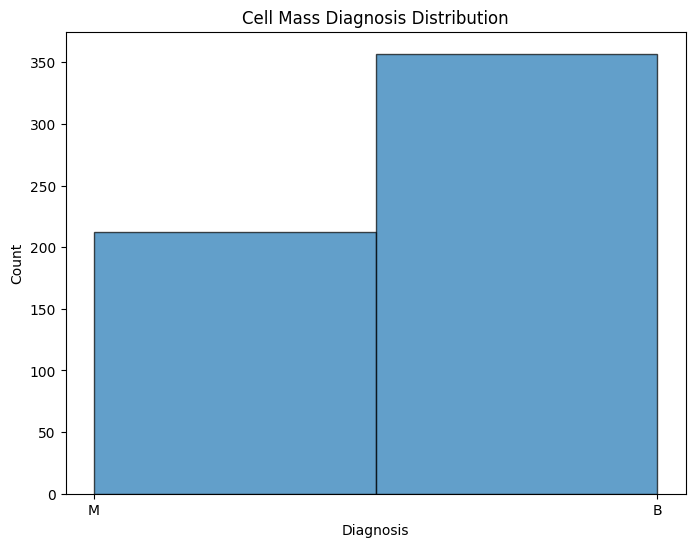

In [5]:
plt.figure(figsize=(8,6))
plt.hist(dataset['diagnosis'], bins=2, edgecolor='black', alpha=.7)

plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Cell Mass Diagnosis Distribution')

#### Since the features are all continuous and the task is binary classification, I will train a Support Vector Machine
- NOTE: 'B' will be mapped to 1 and 'M' will be mapped to '-1'

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [7]:
mapping = {'B': 1, 'M': -1}
dataset['diagnosis'] = dataset['diagnosis'].map(mapping)

In [8]:
diagnoses = dataset['diagnosis']
cell_features = dataset.drop(['diagnosis'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(cell_features, diagnoses, test_size=0.2, random_state=11)

#### Fit Pipeline w/ following Stages:
- StandardScaler to normalize all these continuous features
- GridSearch to find the best hyperparameter combination for SVM

##### Note: class_weight is set to penalize very heavily for malignant misclassifications. Reducing False Positive Rate is a priority

In [9]:
#standard scaler will fit once when diagnosis_pipeline is fit
# then GridSearchCV will run over param space and since refit=True, best_estimator_ will be used in predict calls
#referenced in more detail in this stackoverflow article: https://stackoverflow.com/questions/43366561/use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once
diagnosis_pipeline = make_pipeline(
                        StandardScaler(), 
                        GridSearchCV(SVC(class_weight={1: 1, -1: 20}, probability=True), 
                                    {
                                        'C':[.001, .01, .1, 1, 10, 100],
                                        'gamma': [.001, .01, .1, 1, 10, 100],
                                        'degree': [1, 2, 3, 4, 5],
                                        'kernel': ['poly', 'rbf']
                                    },
                                    cv=3,
                                    refit=True)
)



diagnosis_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=3,
                              estimator=SVC(class_weight={-1: 20, 1: 1},
                                            probability=True),
                              param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                          'degree': [1, 2, 3, 4, 5],
                                          'gamma': [0.001, 0.01, 0.1, 1, 10,
                                                    100],
                                          'kernel': ['poly', 'rbf']}))])

#### Look at Grid Search result

In [10]:
gs = diagnosis_pipeline.named_steps['gridsearchcv']
print(f"Best SVM Parameters: {gs.best_params_}")
print(f"Best Estimator Coss Validation Accuracy: {gs.best_score_}")

Best SVM Parameters: {'C': 100, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Estimator Coss Validation Accuracy: 0.9670326478447775


#### Predict Test Diagnoses and Analyze Accuracy

In [11]:
predictions = diagnosis_pipeline.predict_proba(X_test)[:, 0]
predictions = np.where(predictions >= .9, -1, 1)

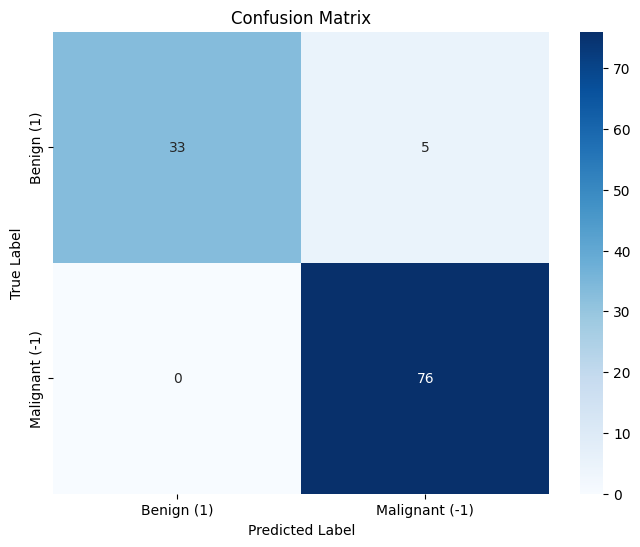

              precision    recall  f1-score   support

          -1       1.00      0.87      0.93        38
           1       0.94      1.00      0.97        76

    accuracy                           0.96       114
   macro avg       0.97      0.93      0.95       114
weighted avg       0.96      0.96      0.96       114



In [12]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign (1)', 'Malignant (-1)'], yticklabels=['Benign (1)', 'Malignant (-1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, predictions))

#### Determine Feature Importance

/var/folders/8_/sbmlvc1j3558q2vfdwxv22_w0000gn/T/ipykernel_76017/43021235.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Cell Features', data=feature_importance, palette='viridis')


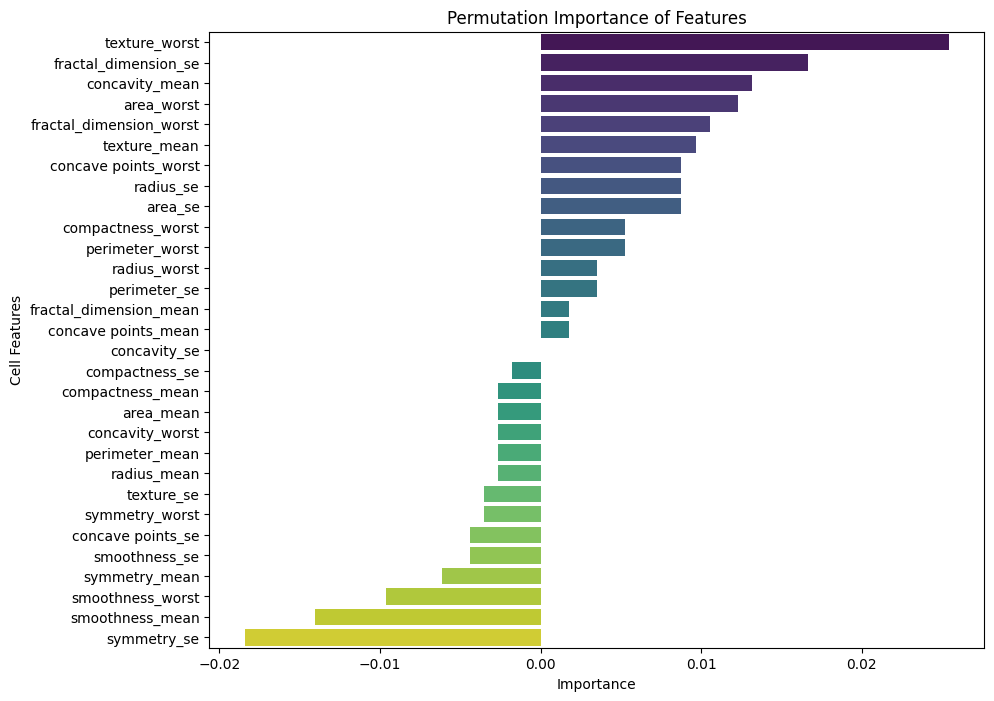

In [13]:
result = permutation_importance(diagnosis_pipeline, X_test, y_test, n_repeats=10, random_state=11)

feature_importance = pd.DataFrame({
    'Cell Features': cell_features.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Cell Features', data=feature_importance, palette='viridis')
plt.title('Permutation Importance of Features')
plt.show()

## Conclusion

#### Reducing False Positive Rate
- To reduce false positives, the following actions were taken:
    - Increased Malignant(-1) misclassification penalty for training. A 20:1 (Malignant: Benign) penalty ratio was used
    - When predicting on test set, a threshold of .9 was used for classifying a cell mass as Bengin (1)
    - This emphasis on reducing false positives actually decreased accuracy because several more examples were classified as false negatives as a result

#### GridSearch
- Best Parameters: {'C': 100, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
- Best Estimator Coss Validation Accuracy: 0.9670326478447775

#### Accuracy
- The trained SVM achieved an accuracy of .95

#### Feature Importance
- Several features actually had negative impact on the test accuracy which confirms the notion that mean, standard error, and largest across these features are correlated   

#### Next Steps
- The results indicate we achieved a Precision of 1 which is ideal in this task. I wanted to reduce the risk of False Positives as much as possible. Consulting physicians for a proper threshold would be ideal, as I am currently just using .9 as a theshold value
- The feature importance graph indicates that several features may actually just hold redundant information so a new model with dropped features would be ideal